# Importing Necessary Libraries

In [4]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import f_classif
from sklearn.metrics import accuracy_score
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import tensorflow as tf
import seaborn as sns
import pandas as pd
import os
import numpy as np
from math import ceil
%matplotlib inline

if not os.path.exists('plots'):
    os.makedirs('plots')

# Reading Metadata

In [5]:
metadata = pd.read_csv('data/metadata.csv')
train_labels = pd.read_csv('data/train_labels.csv')
all_ids = list(metadata.sample_id)
metadata.head()

,sample_id,split,derivatized,features_path,features_md5_hash
0,S0000,train,NaN,train_features/S0000.csv,52ec6d6f8372500ab4e069b5fbdae6f9
1,S0001,train,NaN,train_features/S0001.csv,348f90baed8a8189bf0d4c7b9ed9f965
2,S0002,train,1.0,train_features/S0002.csv,4686ad9bc3716966f63b6ff83d1d8324
3,S0003,train,NaN,train_features/S0003.csv,de6b53605c5887967dc3661a3a711c2b
4,S0004,train,NaN,train_features/S0004.csv,fbfd90092d10d15a5d6919327ddde2ab


# Required Utility Functions

In [6]:

def metadata_parser(metadata):
    train_dict = {}
    val_dict = {}
    for row in metadata.iterrows():
        if row[1].split == 'train':
            train_dict[row[1].sample_id] = row[1].features_path
        else:
            val_dict[row[1].sample_id] = row[1].features_path
    return train_dict, val_dict

def train_label_parser(train_labels):
    train_labels_dict = {}
    for row in train_labels.iterrows():
        row_list = list(row[1])
        train_labels_dict[row_list[0]] = row_list[1:]
    columns = list(train_labels.columns)
    return train_labels_dict, columns[1:]

def get_ids_per_class():
    ids_per_class = {}
    for class_name in labels:
        index = labels.index(class_name)
        ids = []
        for key, value in train_labels_dict.items():
            if value[index] == 1:
                ids.append(key)
        ids_per_class[class_name] = ids
    return ids_per_class

def find_absolute_maximum_mass():
    print("Finding absolute maximum mass")
    pb = tqdm(total=len(all_ids))
    absolute_max = 0
    for key, value in all_paths.items():
        pb.update(1)
        data = pd.read_csv(value)
        data.sort_values('mass')
        max_mass = data['mass'].max()
        absolute_max = max(absolute_max, max_mass)
    return absolute_max

def data_parser(id):
    path = all_paths[id]
    data = pd.read_csv(path)
    data = data.sort_values('mass')
    labels = list(data.columns)
    data_json = {
        'time': np.array(data.time),
        'mass': np.array(data.mass),
        'intensity': np.array(data.intensity),
    }
    return data_json

def descretize(data, mass_range, interval):
    mass = data['mass'].copy()
    intensity = data['intensity'].copy()
    num_elements = int(mass_range / interval) + 1
    intensity_desc = np.zeros(num_elements)
    for i in range(num_elements):
        mass_start = i * interval
        mass_end = (i + 1) * interval
        mask = (mass >= mass_start) & (mass < mass_end)
        if np.any(mask):
            intensity_desc[i] = np.max(intensity[mask])
    return intensity_desc

def intensity_vs_mass_plotter(sample_id, discretized=False, mass_range=650, interval=0.5, path=None):
    data = data_parser(sample_id)
    if discretized:
        data['intensity'] = descretize(data, mass_range, interval)
        data['mass'] = np.array([i*interval for i in range(len(data['intensity']))])
    fig, axs = plt.subplots(figsize=(20, 10))
    axs.set_xlim(0, 650)
    axs.set_title(f'Intensity vs Mass for sample {sample_id}')
    axs.set_xlabel('Mass')
    axs.set_ylabel('Intensity')
    axs.plot(data['mass'], data['intensity'])
    if path:
        fig.savefig(path, bbox_inches='tight')

def abosulte_average_deviation():
    deviations = 0
    count = 0
    for sample_id in tqdm(all_ids):
        data = data_parser(sample_id)
        mass = data['mass']
        for i in range(len(mass) - 1):
            deviations += np.abs(mass[i+1] - mass[i])
            count += 1
    return deviations, count


def descritize_dataset(dataset_path, max_mass, step, file_name):
    columns = ['sample_id']
    num_elements = int(max_mass / step) + 1
    for i in range(num_elements):
        columns.append(f'I{i}')

    data_rows = []
    for key, value in tqdm(dataset_path.items()):
        data = data_parser(key)
        intensity_desc = descretize(data, max_mass, step)
        max_intensity = np.max(intensity_desc)
        normalized_intensity_desc = [i / max_intensity for i in intensity_desc]
        row = [key] + normalized_intensity_desc
        data_rows.append(row)

    df = pd.DataFrame(data_rows, columns=columns)
    df.to_csv(file_name, index=False)

# Finding Dataset Constants

In [7]:
# The below functions were already run and the results are stored in the
# variables below. Uncomment the below lines to run the functions again.
# absolute_maximum_mass = find_absolute_maximum_mass()
# absolute_average_deviation, total_count = abosulte_average_deviation()

# Below are the values for absolute maximum mass and absolute mean difference
absolute_maximum_mass = 649.96228
absolute_mean_diff = 544345.6024272853/591544015
print("Absolute maximum mass: ", absolute_maximum_mass)
print("Absolute mean difference: ", absolute_mean_diff)

# This absolute maximum was used to descrtize the dataset

Absolute maximum mass:  649.96228
Absolute mean difference:  0.0009202114950436702


# Extracting Dataset into Data Structures

In [8]:
train_path, val_path = metadata_parser(metadata)
train_labels_dict, labels = train_label_parser(train_labels)
all_paths = {**train_path, **val_path}
ids_per_class = get_ids_per_class()

# Save Descritized Dataset

In [9]:
# Saved Descritized datasets are already generated and stored in the repository
# Uncomment the below lines to generate the descritized datasets again
# - data/train_descrete.csv
# - data/val_descrete.csv

# print("Descretizing train dataset")
# descritize_dataset(dataset_path=train_path, 
#                     max_mass=ceil(absolute_maximum_mass), 
#                     step=0.1, 
#                     file_name="data/train_descrete.csv")


# print("Descretizing test dataset")
# descritize_dataset(dataset_path=val_path, 
#                    max_mass=ceil(absolute_maximum_mass), 
#                    step=0.1, 
#                    file_name="data/val_descrete.csv")

# Load Descritized Dataset into Numpy Array

In [10]:
def return_descrete_data(path, labels_dict=None):
    data = pd.read_csv(path)
    sample_ids = list(data.sample_id)
    data.drop('sample_id', axis=1, inplace=True)
    X = np.array(data)
    y = []
    if labels_dict is not None:
        for sample_id in sample_ids:
            y.append(labels_dict[sample_id])
    return X, np.array(y)

X, y = return_descrete_data('data/train_descrete.csv', train_labels_dict)
input_shape = X.shape[1]
X.shape, y.shape

((809, 6501), (809, 9))

# Plotter and Saver Callbacks

In [11]:
def evaluate_model(model, X_val, y_val, plot_path=None, history=None):
    # Plot the training and validation loss
    if history is not None:
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(1, len(train_loss) + 1)

        plt.figure(figsize=(10, 7))
        plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
        plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig("plots/loss.png")
        plt.show()


        train_acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        epochs = range(1, len(train_acc) + 1)

        plt.figure(figsize=(10, 7))
        plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
        plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.savefig("plots/accuracy.png")
        plt.show()
    y_pred = model.predict(X_val, verbose=False).round()
    class_rep = classification_report(y_val, y_pred)
    confusion_matrix = multilabel_confusion_matrix(y_val, y_pred)
    print(class_rep)
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    
    eps = 1e-7
    per_label_log_loss = -(y_val * np.log(y_pred+eps) + (1 - y_val) * np.log(1 - y_pred+eps))
    aggregated_log_loss = np.mean(per_label_log_loss)
    
    # Random Loss
    prob = y_val.sum()/(y_val.shape[0]*y_val.shape[1])
    y_random = np.random.binomial(1, prob, y_val.shape)
    per_label_log_loss_rand = -(y_val * np.log(y_random+eps) + (1 - y_val) * np.log(1 - y_random+eps))
    aggregated_log_loss_rand = np.mean(per_label_log_loss_rand)

    axes = axes.flatten()
    for i, matrix in enumerate(confusion_matrix):
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i])
        axes[i].set_title(f'{labels[i]} Confusion Matrix')
        axes[i].set_xlabel('Predicted Label')
        axes[i].set_ylabel('True Label')

    plt.tight_layout()
    if plot_path:
        plt.savefig(plot_path)
    plt.show()
    
    print("Log Loss: ", aggregated_log_loss)
    print("Log Loss Random: ", aggregated_log_loss_rand)
    print("Accuracy: ", np.all(y_pred==y_val, axis=1).mean()*100, "%")
    print("--------------------------------------------")


class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, model):
        super(CustomCallback, self).__init__()
        self.model = model
        self.min_score = 100

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(X_val, verbose=False).round()
        eps = 1e-7
        per_label_log_loss = -(y_val * np.log(y_pred+eps) + (1 - y_val) * np.log(1 - y_pred+eps))
        aggregated_log_loss = np.mean(per_label_log_loss)
        if aggregated_log_loss < self.min_score:
            if os.path.exists('mystic_model.h5'):
                os.remove('mystic_model.h5')
            self.model.save('mystic_model.h5')
            self.min_score = aggregated_log_loss

# Creating the Model

In [12]:
def multilabel_aggregated_log_loss(y_true, y_pred):
    epsilon = 1e-7
    y_true = tf.cast(y_true, tf.float32)
    per_label_log_loss = -(y_true * tf.math.log(y_pred+epsilon) + (1 - y_true) * tf.math.log(1 - y_pred+epsilon))
    aggregated_log_loss = tf.reduce_mean(per_label_log_loss)
    return aggregated_log_loss

def train_tf_model(X_train, y_train, X_val, y_val, input_shape):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, mode='auto', min_delta=0.001)
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(640, activation='relu', input_shape=(input_shape,)))
    model.add(tf.keras.layers.Dense(320, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(160, activation='relu'))
    model.add(tf.keras.layers.Dense(120, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(100, activation='relu'))
    model.add(tf.keras.layers.Dense(80, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(40, activation='relu'))
    model.add(tf.keras.layers.Dense(20, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(9, activation='sigmoid'))

    model.compile(optimizer='adam', loss=multilabel_aggregated_log_loss, metrics=['accuracy'])
    checkpoint = CustomCallback(model)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=400, batch_size=32, verbose=True, callbacks=[checkpoint])
    model_tf = tf.keras.models.load_model('mystic_model.h5', custom_objects={
                                          'multilabel_aggregated_log_loss': multilabel_aggregated_log_loss})
    return model, history

# Training the Model

In [14]:
# Train data split into Training and Validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=100)
# Validation data split into Validation and Evaluation data
X_val, X_eval, y_val, y_eval = train_test_split(X_val, y_val, test_size=0.5, random_state=120)
# Training the Model
model_tf, history_tf = train_tf_model(X_train, y_train, X_val, y_val, X_train.shape[1])

Epoch 1/400
22/22 [==============================] - 3s 61ms/step - loss: 0.6329 - accuracy: 0.1790 - val_loss: 0.5323 - val_accuracy: 0.3115
Epoch 2/400
22/22 [==============================] - 1s 45ms/step - loss: 0.4929 - accuracy: 0.1921 - val_loss: 0.3840 - val_accuracy: 0.3115
Epoch 3/400
22/22 [==============================] - 1s 46ms/step - loss: 0.3635 - accuracy: 0.2154 - val_loss: 0.2660 - val_accuracy: 0.3770
Epoch 4/400
22/22 [==============================] - 1s 48ms/step - loss: 0.2701 - accuracy: 0.3115 - val_loss: 0.2138 - val_accuracy: 0.4262
Epoch 5/400
22/22 [==============================] - 1s 46ms/step - loss: 0.2226 - accuracy: 0.3523 - val_loss: 0.2153 - val_accuracy: 0.3934
Epoch 6/400
22/22 [==============================] - 1s 50ms/step - loss: 0.2058 - accuracy: 0.3843 - val_loss: 0.1882 - val_accuracy: 0.3934
Epoch 7/400
22/22 [==============================] - 1s 45ms/step - loss: 0.1805 - accuracy: 0.4163 - val_loss: 0.1648 - val_accuracy: 0.4262
Epoch 

# Evaluation of the Model

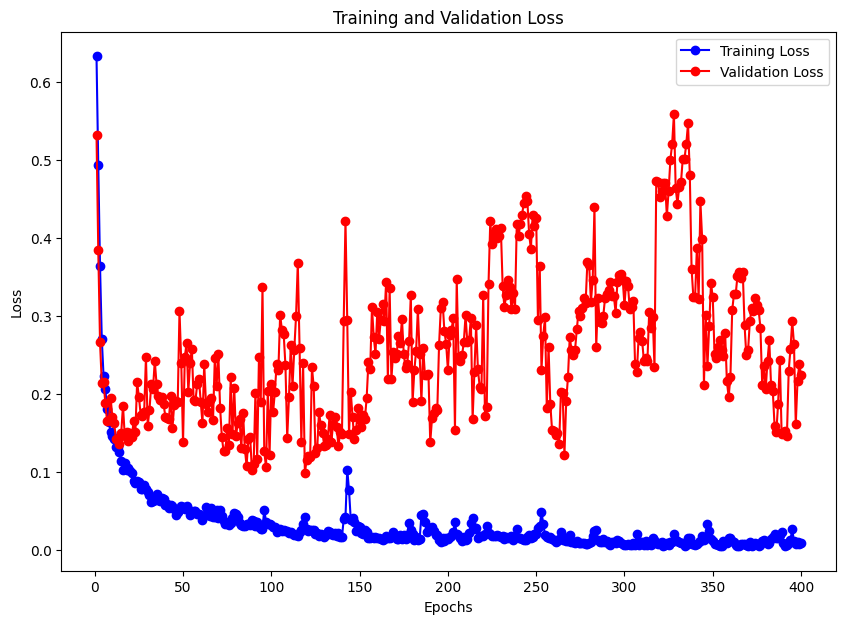

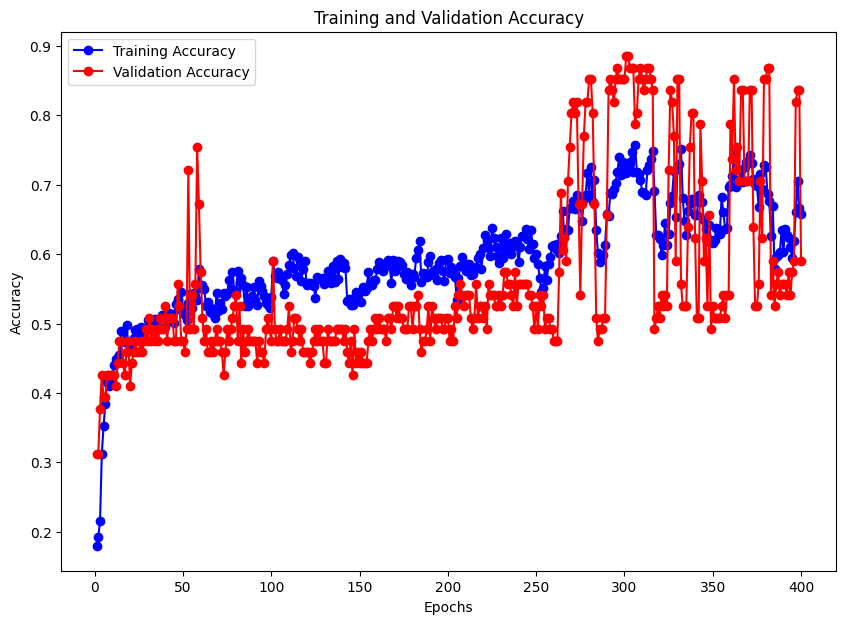

c:\Users\Shashank\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Shashank\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.83      0.83      0.83         6
           1       1.00      1.00      1.00        22
           2       1.00      0.57      0.73         7
           3       0.83      0.71      0.77         7
           4       0.50      0.67      0.57         3
           5       0.75      0.75      0.75         4
           6       0.67      0.50      0.57         4
           7       1.00      1.00      1.00         2
           8       1.00      0.78      0.88         9

   micro avg       0.90      0.81      0.85        64
   macro avg       0.84      0.76      0.79        64
weighted avg       0.91      0.81      0.85        64
 samples avg       0.54      0.55      0.54        64



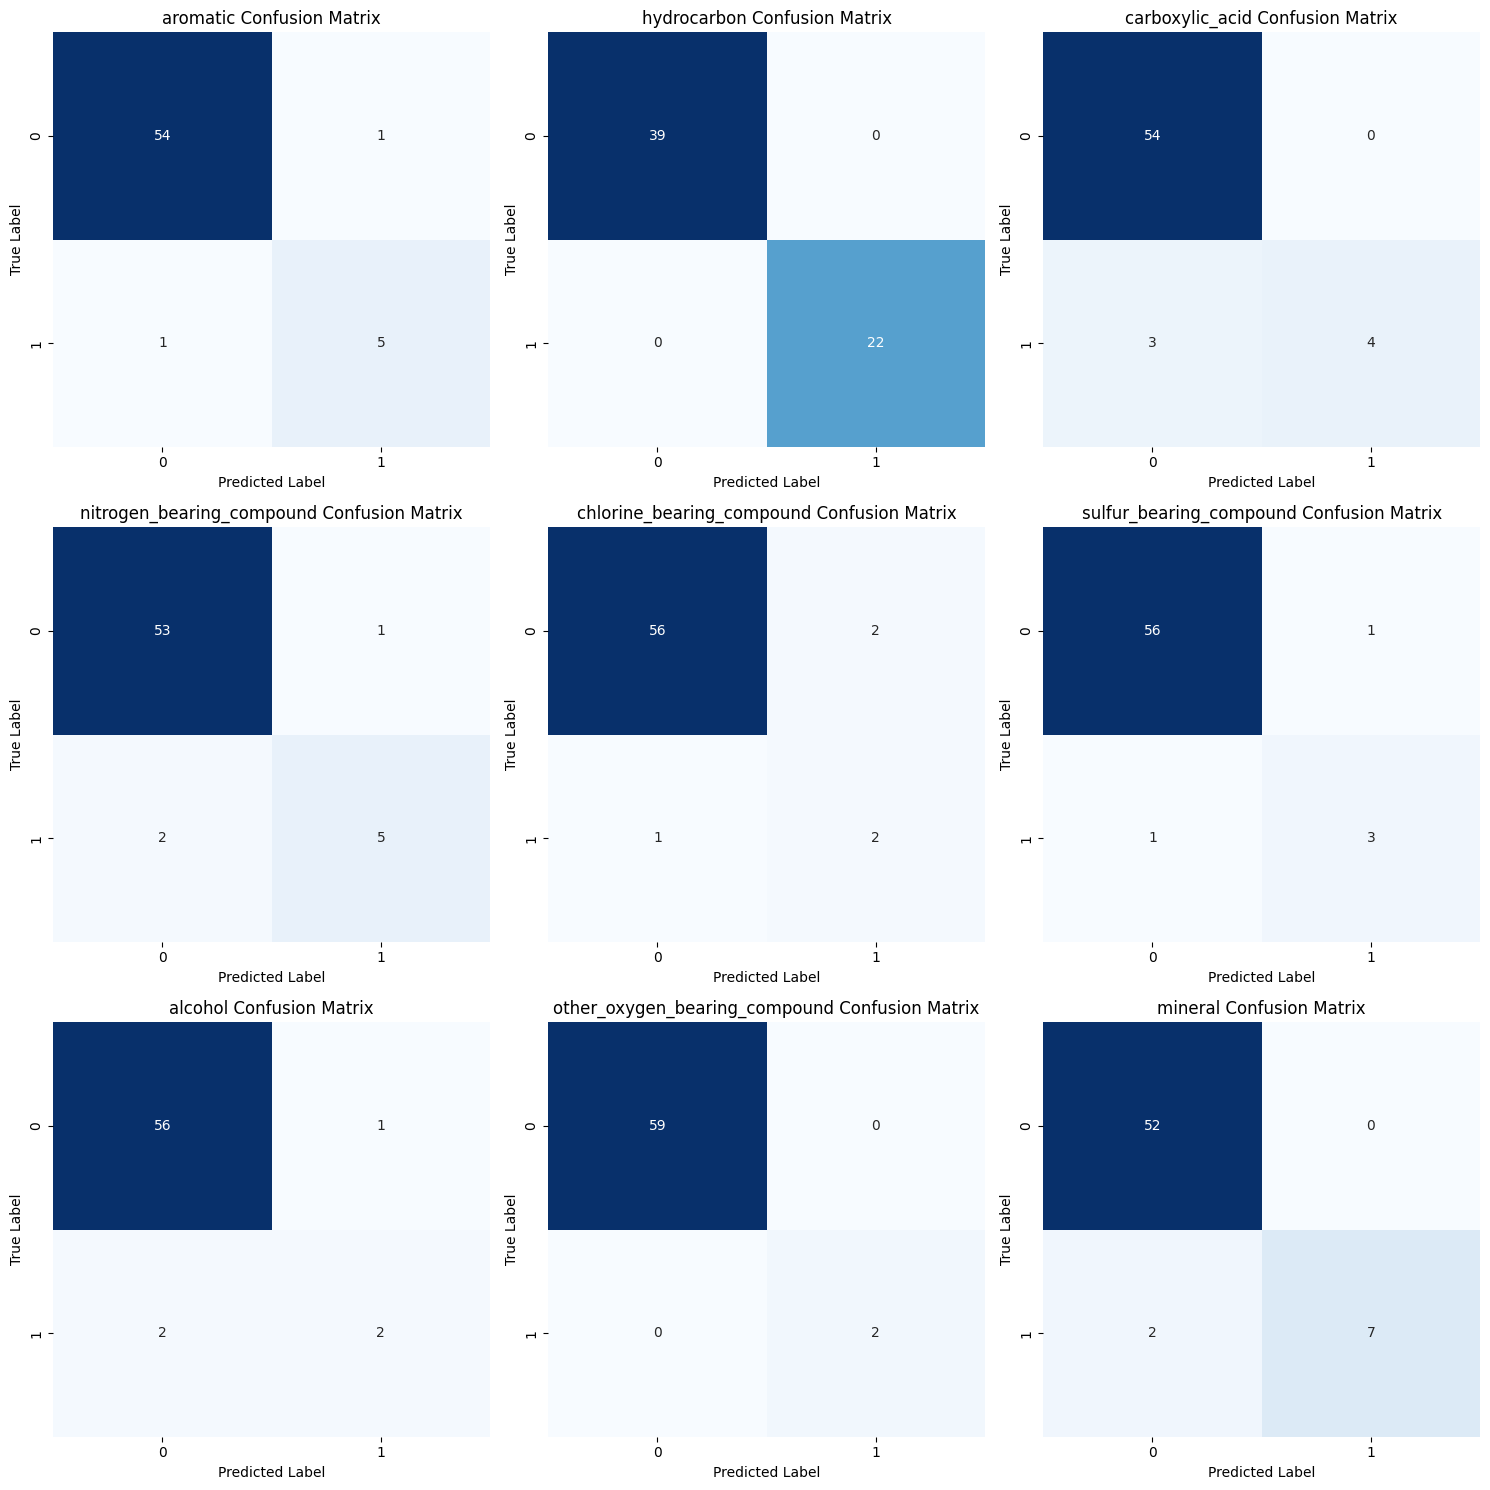

Log Loss:  0.5284620288942817
Log Loss Random:  3.112054817307075
Accuracy:  88.52459016393442 %
--------------------------------------------


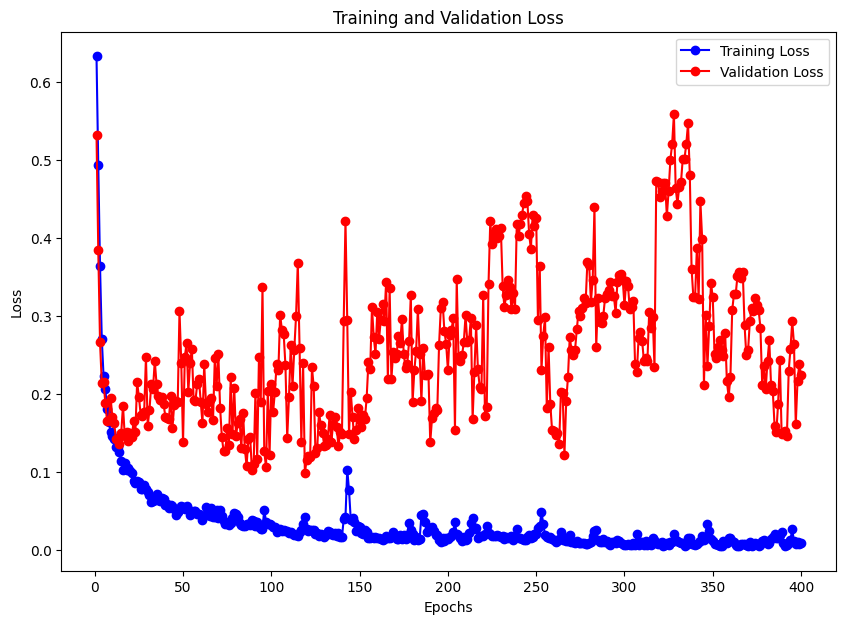

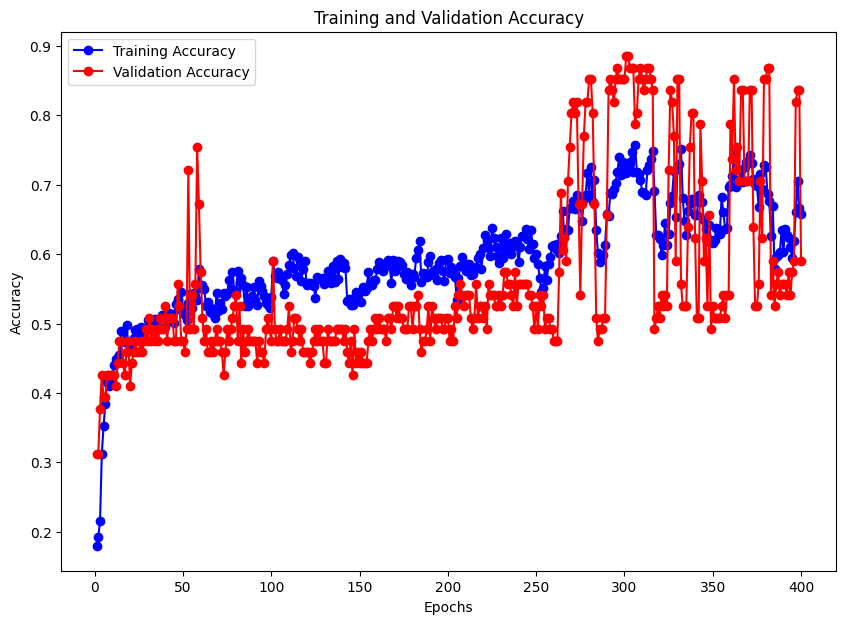

c:\Users\Shashank\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Shashank\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Shashank\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average

              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.94      0.89      0.92        19
           2       0.86      0.60      0.71        10
           3       0.67      0.50      0.57         8
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         2
           8       0.62      0.62      0.62         8

   micro avg       0.77      0.62      0.69        58
   macro avg       0.45      0.37      0.40        58
weighted avg       0.74      0.62      0.67        58
 samples avg       0.46      0.46      0.46        58



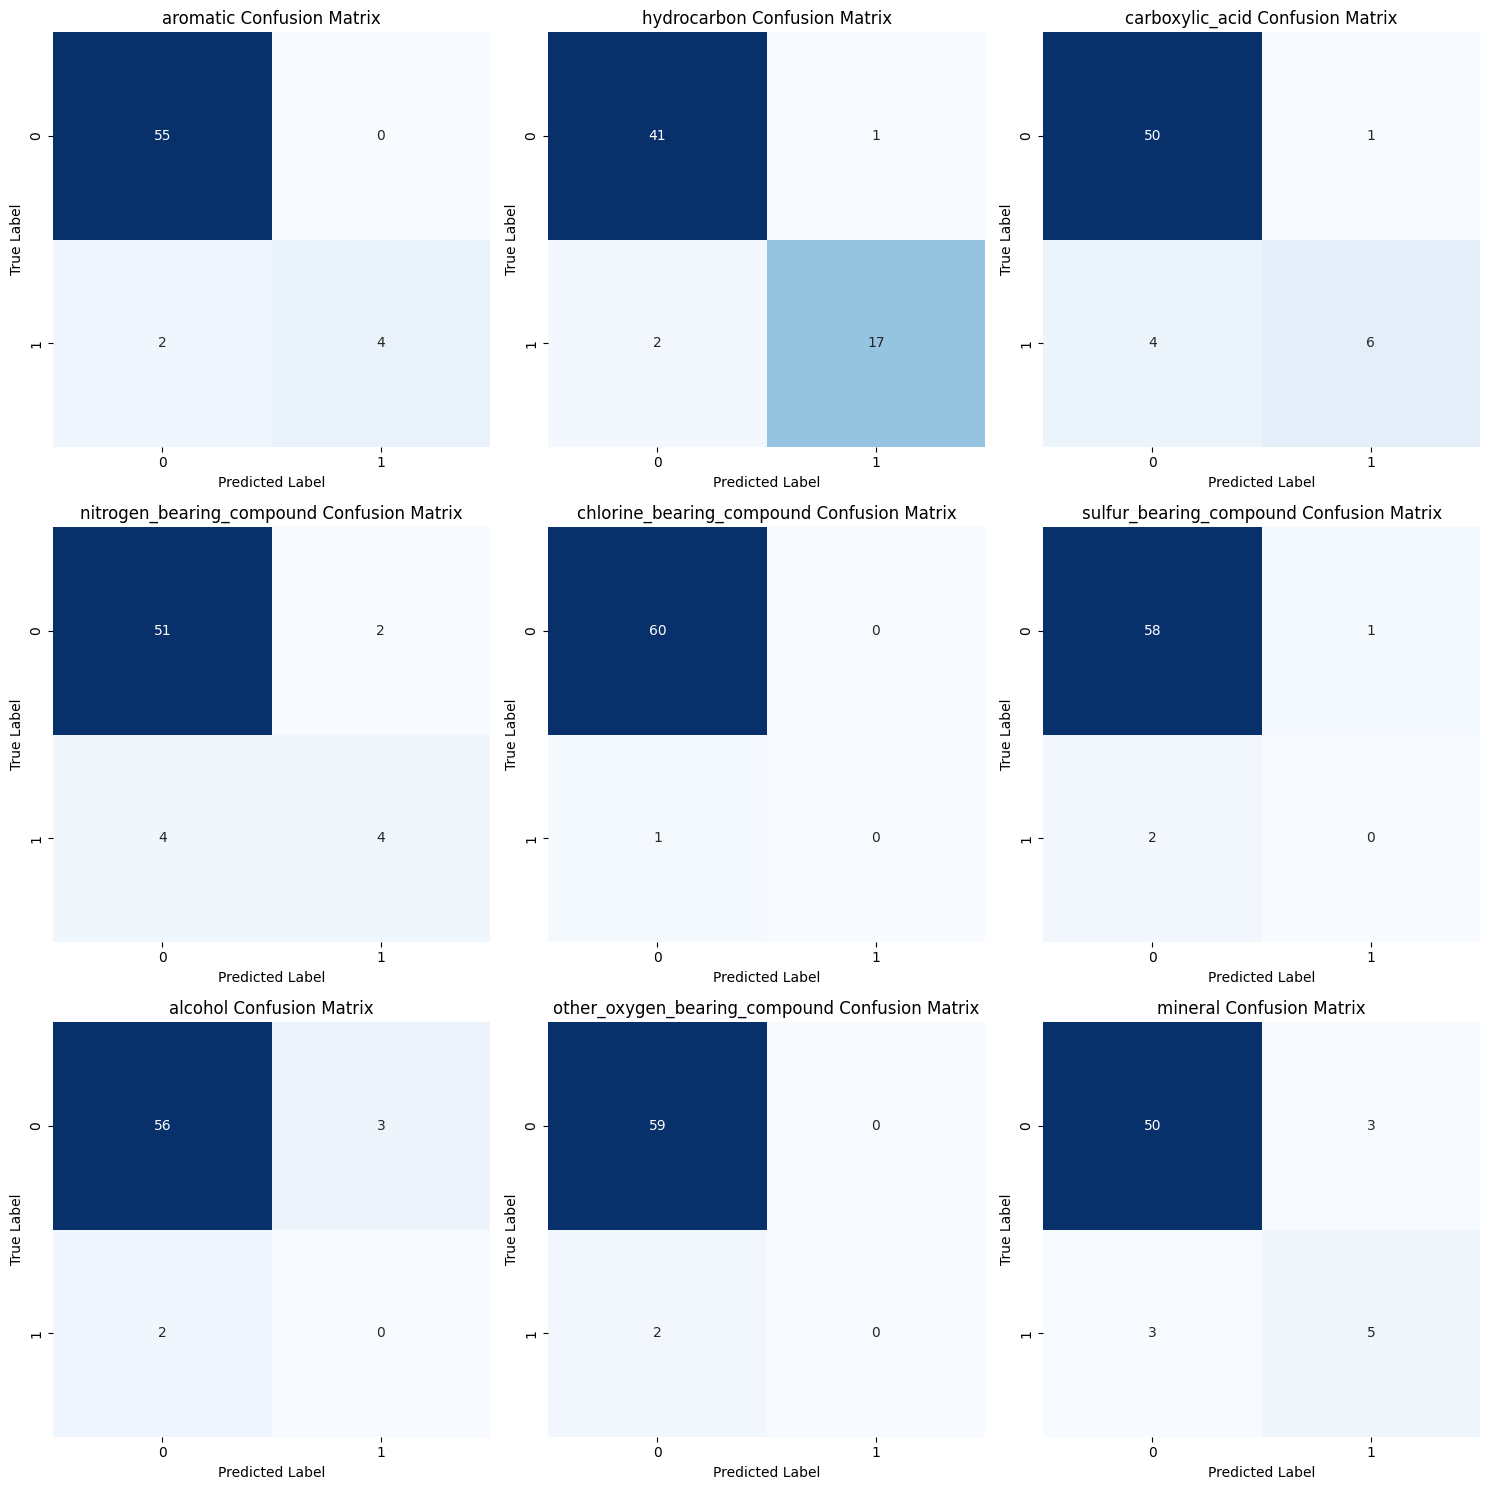

Log Loss:  0.9688471523139129
Log Loss Random:  2.9359007653840337
Accuracy:  77.04918032786885 %
--------------------------------------------


In [15]:
evaluate_model(model_tf, X_val, y_val, plot_path="plots/validation.png", history=history_tf)
evaluate_model(model_tf, X_eval, y_eval,
               plot_path="plots/evaluation.png", history=history_tf)


# Making and Saving Submission File

In [16]:
model_tf = tf.keras.models.load_model('mystic_model.h5', custom_objects={
                                      'multilabel_aggregated_log_loss': multilabel_aggregated_log_loss})
val_data = pd.read_csv('data/val_descrete.csv')
val_data_samples = val_data.sample_id
val_data_values = val_data.drop(['sample_id'], axis=1).values
predictions = model_tf.predict(val_data_values).round()
submission = pd.DataFrame(predictions)
submission.insert(0, 'sample_id', val_data_samples)
new_column_names = {i: label for i, label in enumerate(labels)}
submission.rename(columns=new_column_names, inplace=True)
submission.to_csv('mystic_submission.csv', index=False)

10/10 [==============================] - 0s 4ms/step
